In [43]:
#ALL IMPORTS
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import warnings
import matplotlib.cbook
import matplotlib.ticker as ticker

In [44]:
# Open files and Load DATA
sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\latestStats.json") as f:
    data = json.load(f)

with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\availableServers.json") as f:
    servers = json.load(f)

with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\bw_tests.json") as f:
    bw = json.load(f)

In [45]:
# # Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
servers_df = pd.DataFrame(servers)
dfbw = pd.DataFrame(bw)

# # Convert the avg_latency column to numeric and save it back to the dataframe
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
#print(type(int(servers_df['_id'][0])))
servers_df['_id'] = pd.to_numeric(servers_df['_id'])

# Convert 'hops_number' column to numeric
df['hops_number'] = pd.to_numeric(df['hops_number']).astype(int)

# Remove the timestamp from the _id column and save it back to the dataframe as "serverId_pathId"
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))

# Remove the timestamp from the _id column and save it back to the dataframe as "serverId_pathId"
dfbw['_id'] = dfbw['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))


In [46]:
# Used to create the legend and color stuff

# List of unique destinations in DataFrame
destinations = df['_id'].str.split('_', expand=True)[0].unique()
df['dest'] = df['_id'].str.split('_', expand=True)[0]

# Create a DataFrame with the minimum and maximum hops for each destination
destination_hops_info = df.groupby('dest')['hops_number'].agg(['min', 'max']).reset_index()

# Compute max over 'max' column and min over 'min' column
max_hops = destination_hops_info['max'].max()
min_hops = destination_hops_info['min'].min()
num_hops = max_hops - min_hops + 1
colormap = cm.get_cmap('Set1', num_hops)

# Create a dictionary to map each destination to its color palette
colormap_dict = {}
for destination in destinations:
    # print("ITERATION #", destination)
    min_hops = destination_hops_info[destination_hops_info['dest'].str.startswith(destination)]['min'].iloc[0]
    max_hops = destination_hops_info[destination_hops_info['dest'].str.startswith(destination)]['max'].iloc[0]
    colormap_dict[destination] = {hops: colormap(i) for i, hops in enumerate(range(min_hops, max_hops + 1))}

# Function to assign colors based on destination and hops_number
def assign_color(row):
    destination = row['_id'].split('_')[0]
    hops = row['hops_number']
    return colormap_dict[destination][hops]

# Apply the function to create the 'color' column
df['color'] = df.apply(assign_color, axis=1)

warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\maxbr\AppData\Local\Temp\ipykernel_20168\2579172267.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', num_hops)


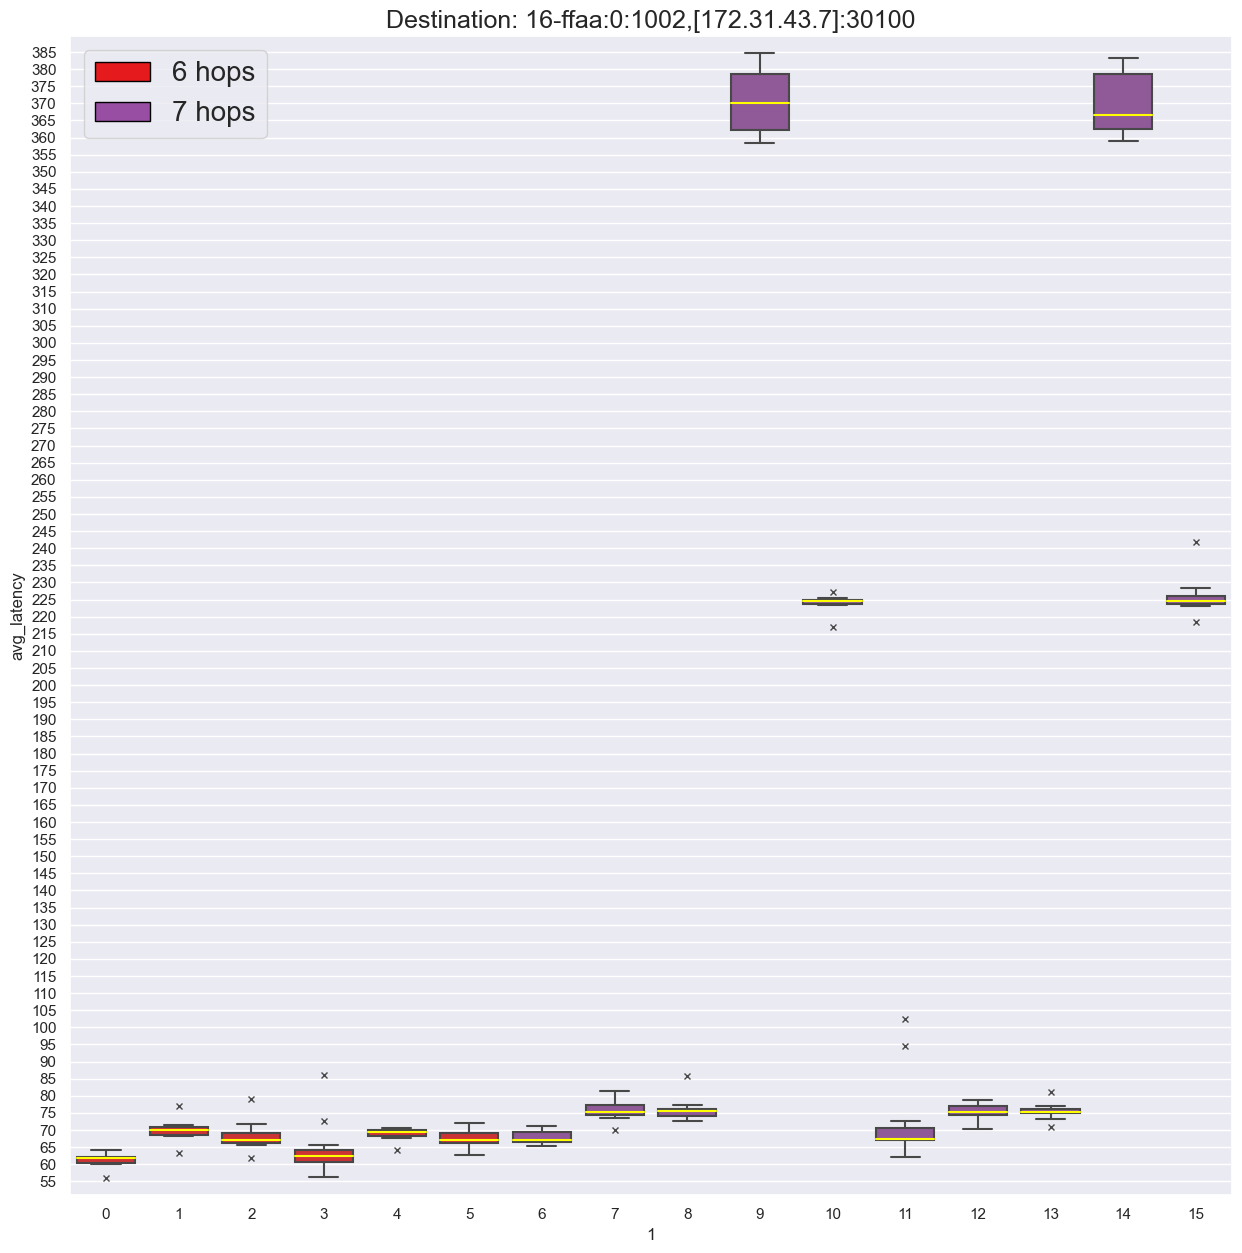

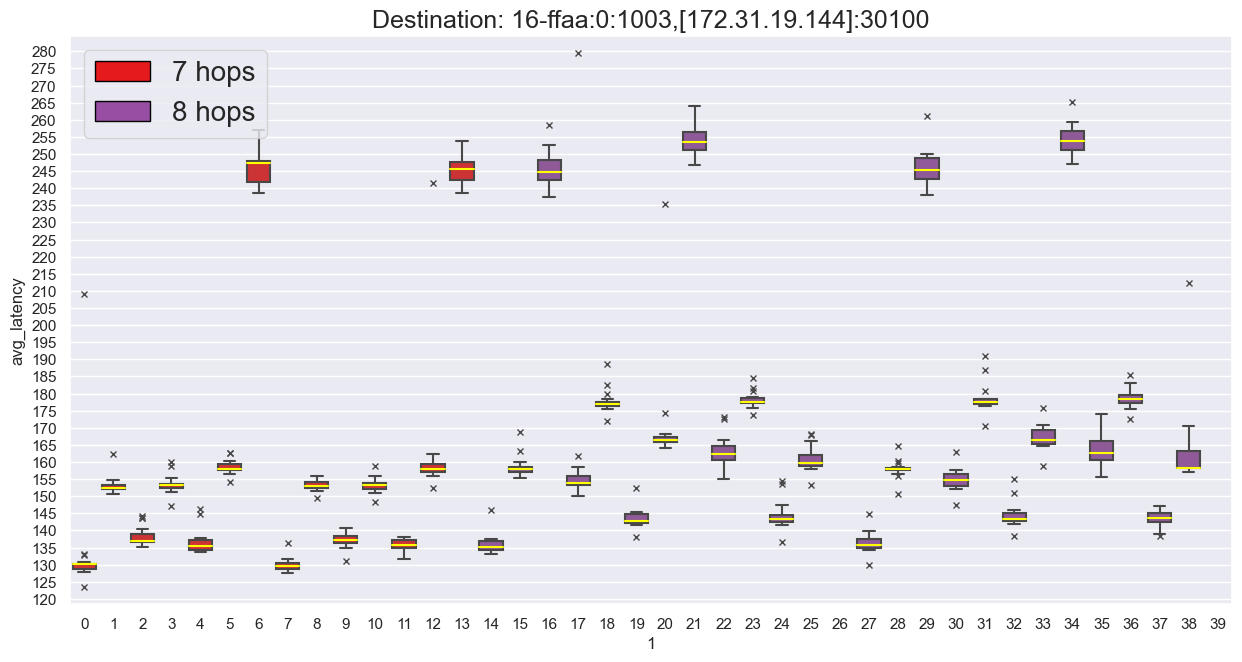

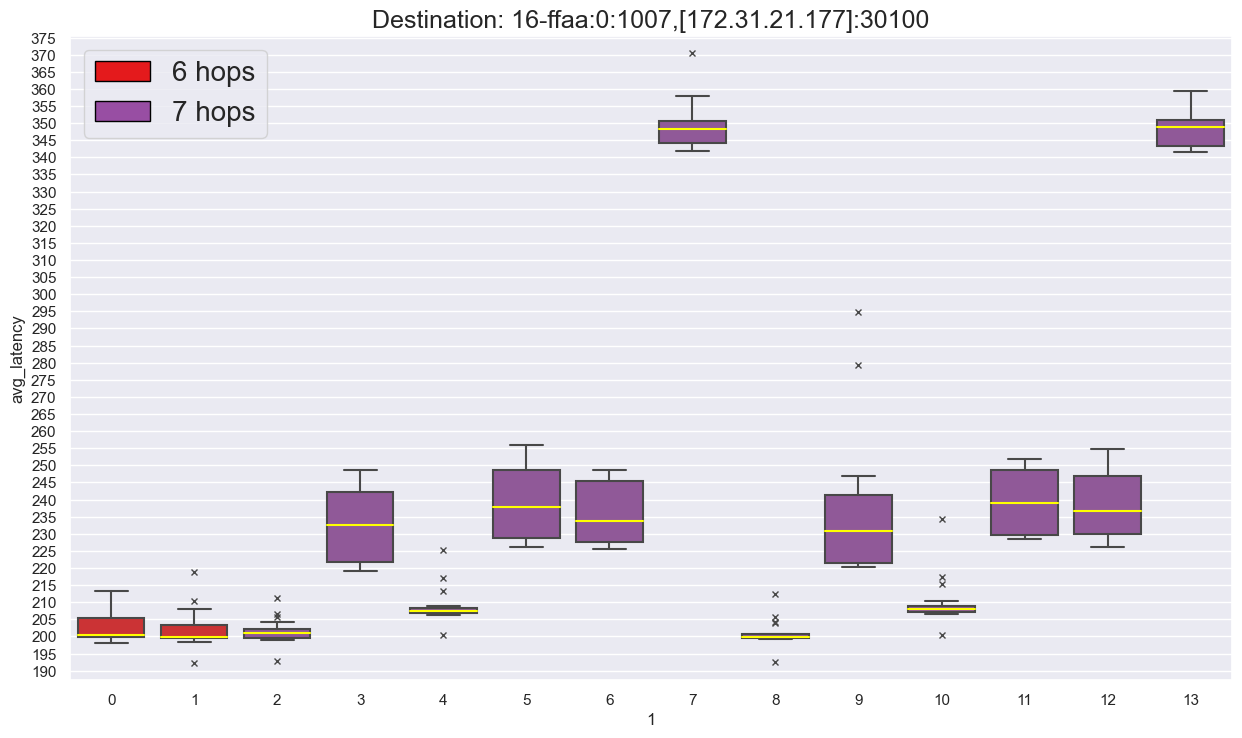

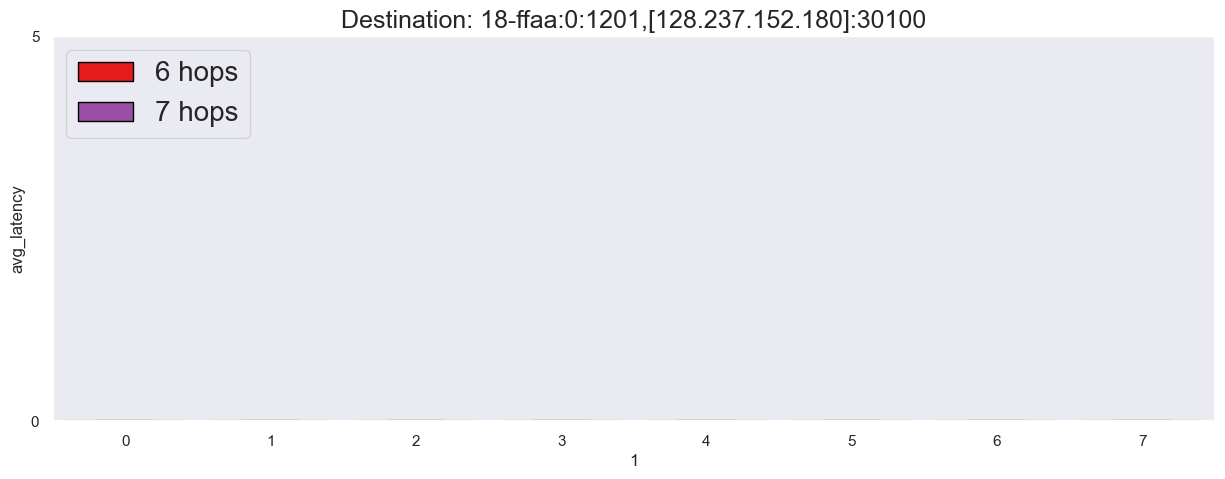

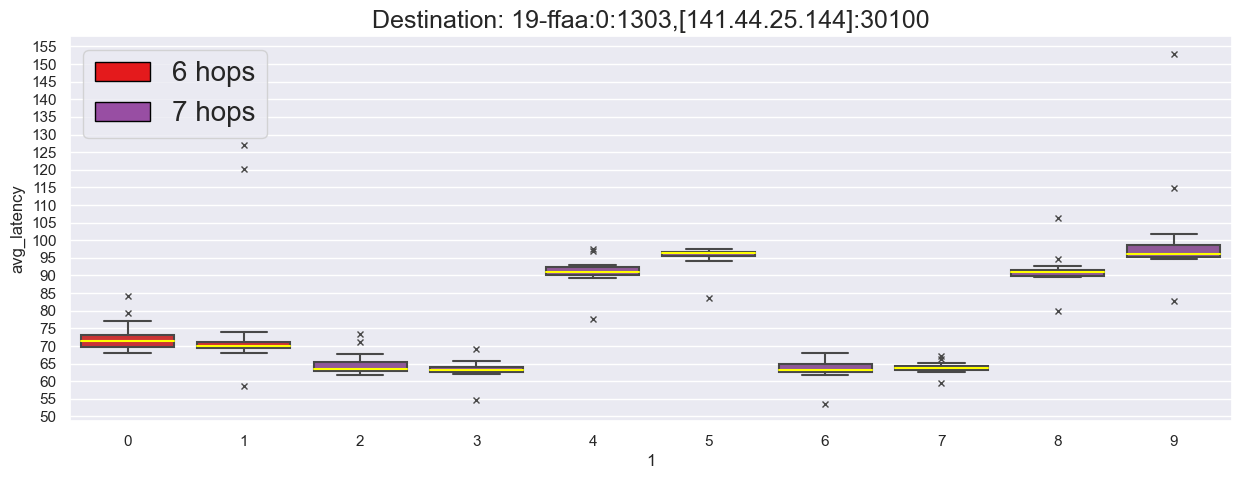

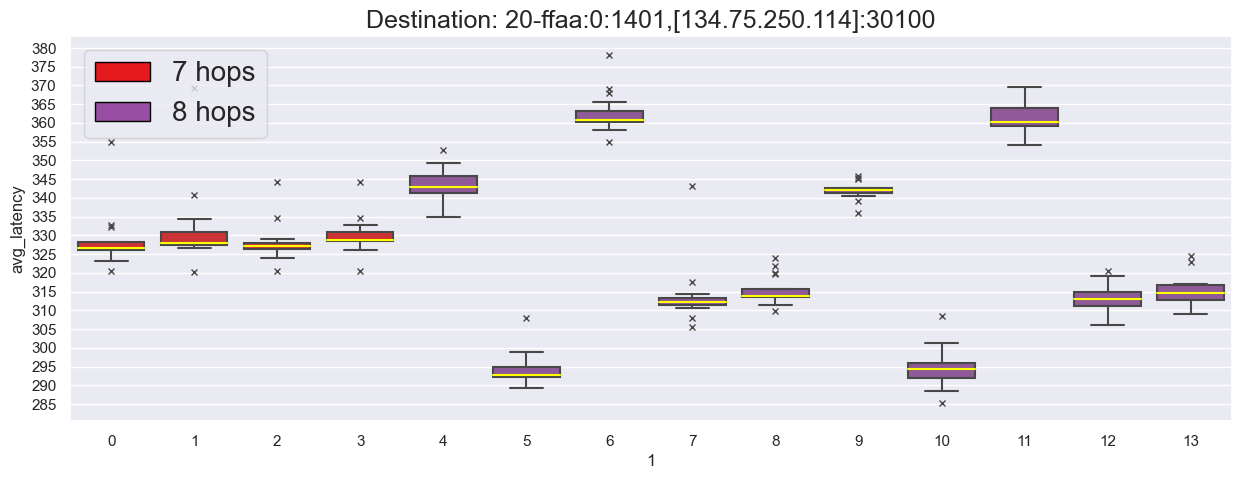

In [47]:
# # THIS IS THE CODE FOR THE PLOT OF THE AVERAGE LATENCY FOR EACH PATH FOR EACH DESTINATION. (WHISKER PLOT)

custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
# Iterate over destinations and create a graph for each
for destination in destinations:
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops +1 
    data = df[df['_id'].str.startswith(destination) & (df['hops_number'] <= min_hops+1)]

    min_latency = data['avg_latency'].min()
    max_latency = data[data['avg_latency'] <= 400]['avg_latency'].max()
    
    lower_bound = max(0, min_latency-5)
    upper_bound = min(400, max_latency+5)

    # print(max_latency)

    graph_height = upper_bound - lower_bound
    
    graph_height = graph_height/22.5 if not (graph_height/22.5) - 5 <= 0 else 5

    # Create a new figure for each destination
    fig, ax = plt.subplots(figsize=(15, graph_height))

    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    ax.set_xlabel("PathID")
    ax.set_ylabel("Average Latency (ms)")

    ax.set_ylim([lower_bound, upper_bound])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Create a sub DataFrame with all the ids for the current destination
    sub_df = [d for i,d in enumerate(data['_id'].unique())]

    # Create a list of colors for each pathID in the current destination
    box_color = [data[data['_id'] == id]['color'].iloc[0] for id in sub_df]

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color)}

    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['_id'].str.split('_', expand=True)[1], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)

    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in sorted_color_hops_dict.keys()]

    legend_labels = [f"{sorted_color_hops_dict[color]} hops" for color in set(sorted_color_hops_dict.keys())]
    legend_labels.sort(key=lambda x: int(x.split()[0]))

    ax.legend(legend_handles, legend_labels, loc='upper left', prop={'size': 20})  # Add the legend to the subplot

    ax.set_title(f"Destination: {server}", fontsize=18)  # Set the title for the subplot

    # Show the current figure
    plt.show()

In [48]:
#Creating a dictionary with the number of destinations for each number of hops

hops_destinations = {}

real_min = -1
higher_min = -1

num_dest = len(destinations)
for destination in destinations:
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()
    if min_hops < real_min or real_min == -1:
        real_min = min_hops
    if min_hops > higher_min or higher_min == -1:
        higher_min = min_hops
    if min_hops in hops_destinations:
        hops_destinations[min_hops] = int(hops_destinations.get(min_hops, 0) + 1)
    else:
        hops_destinations[min_hops] = int(1)

list_of_hops = [i for i in range(real_min, higher_min+1, 1)]


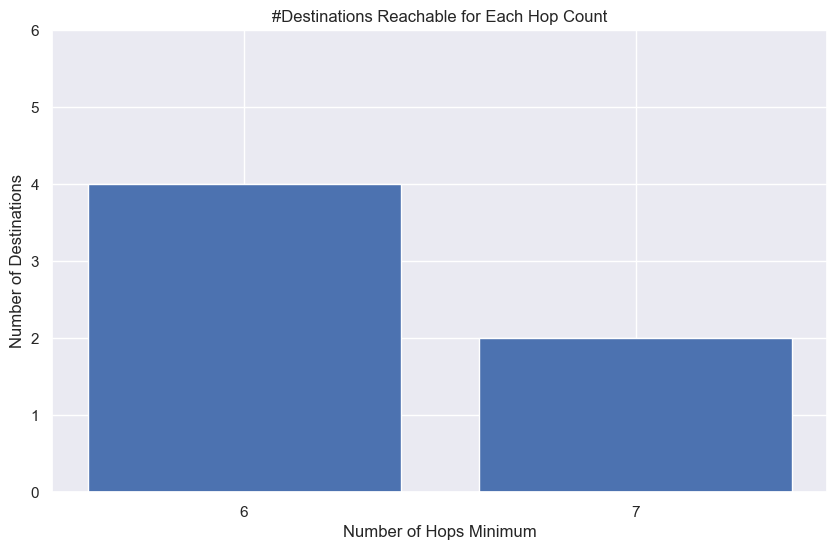

In [49]:
# Create a bar chart with #destination reachable for each hop count
plt.figure(figsize=(10, 6))
plt.bar(hops_destinations.keys(), hops_destinations.values())
plt.xticks(list_of_hops, [str(hops) for hops in list_of_hops])
plt.yticks([i for i in range(0, num_dest+1, 1)])
# Set the labels and title
plt.xlabel('Number of Hops Minimum')
plt.ylabel('Number of Destinations')
plt.title('#Destinations Reachable for Each Hop Count')

# Show the plot
plt.show()


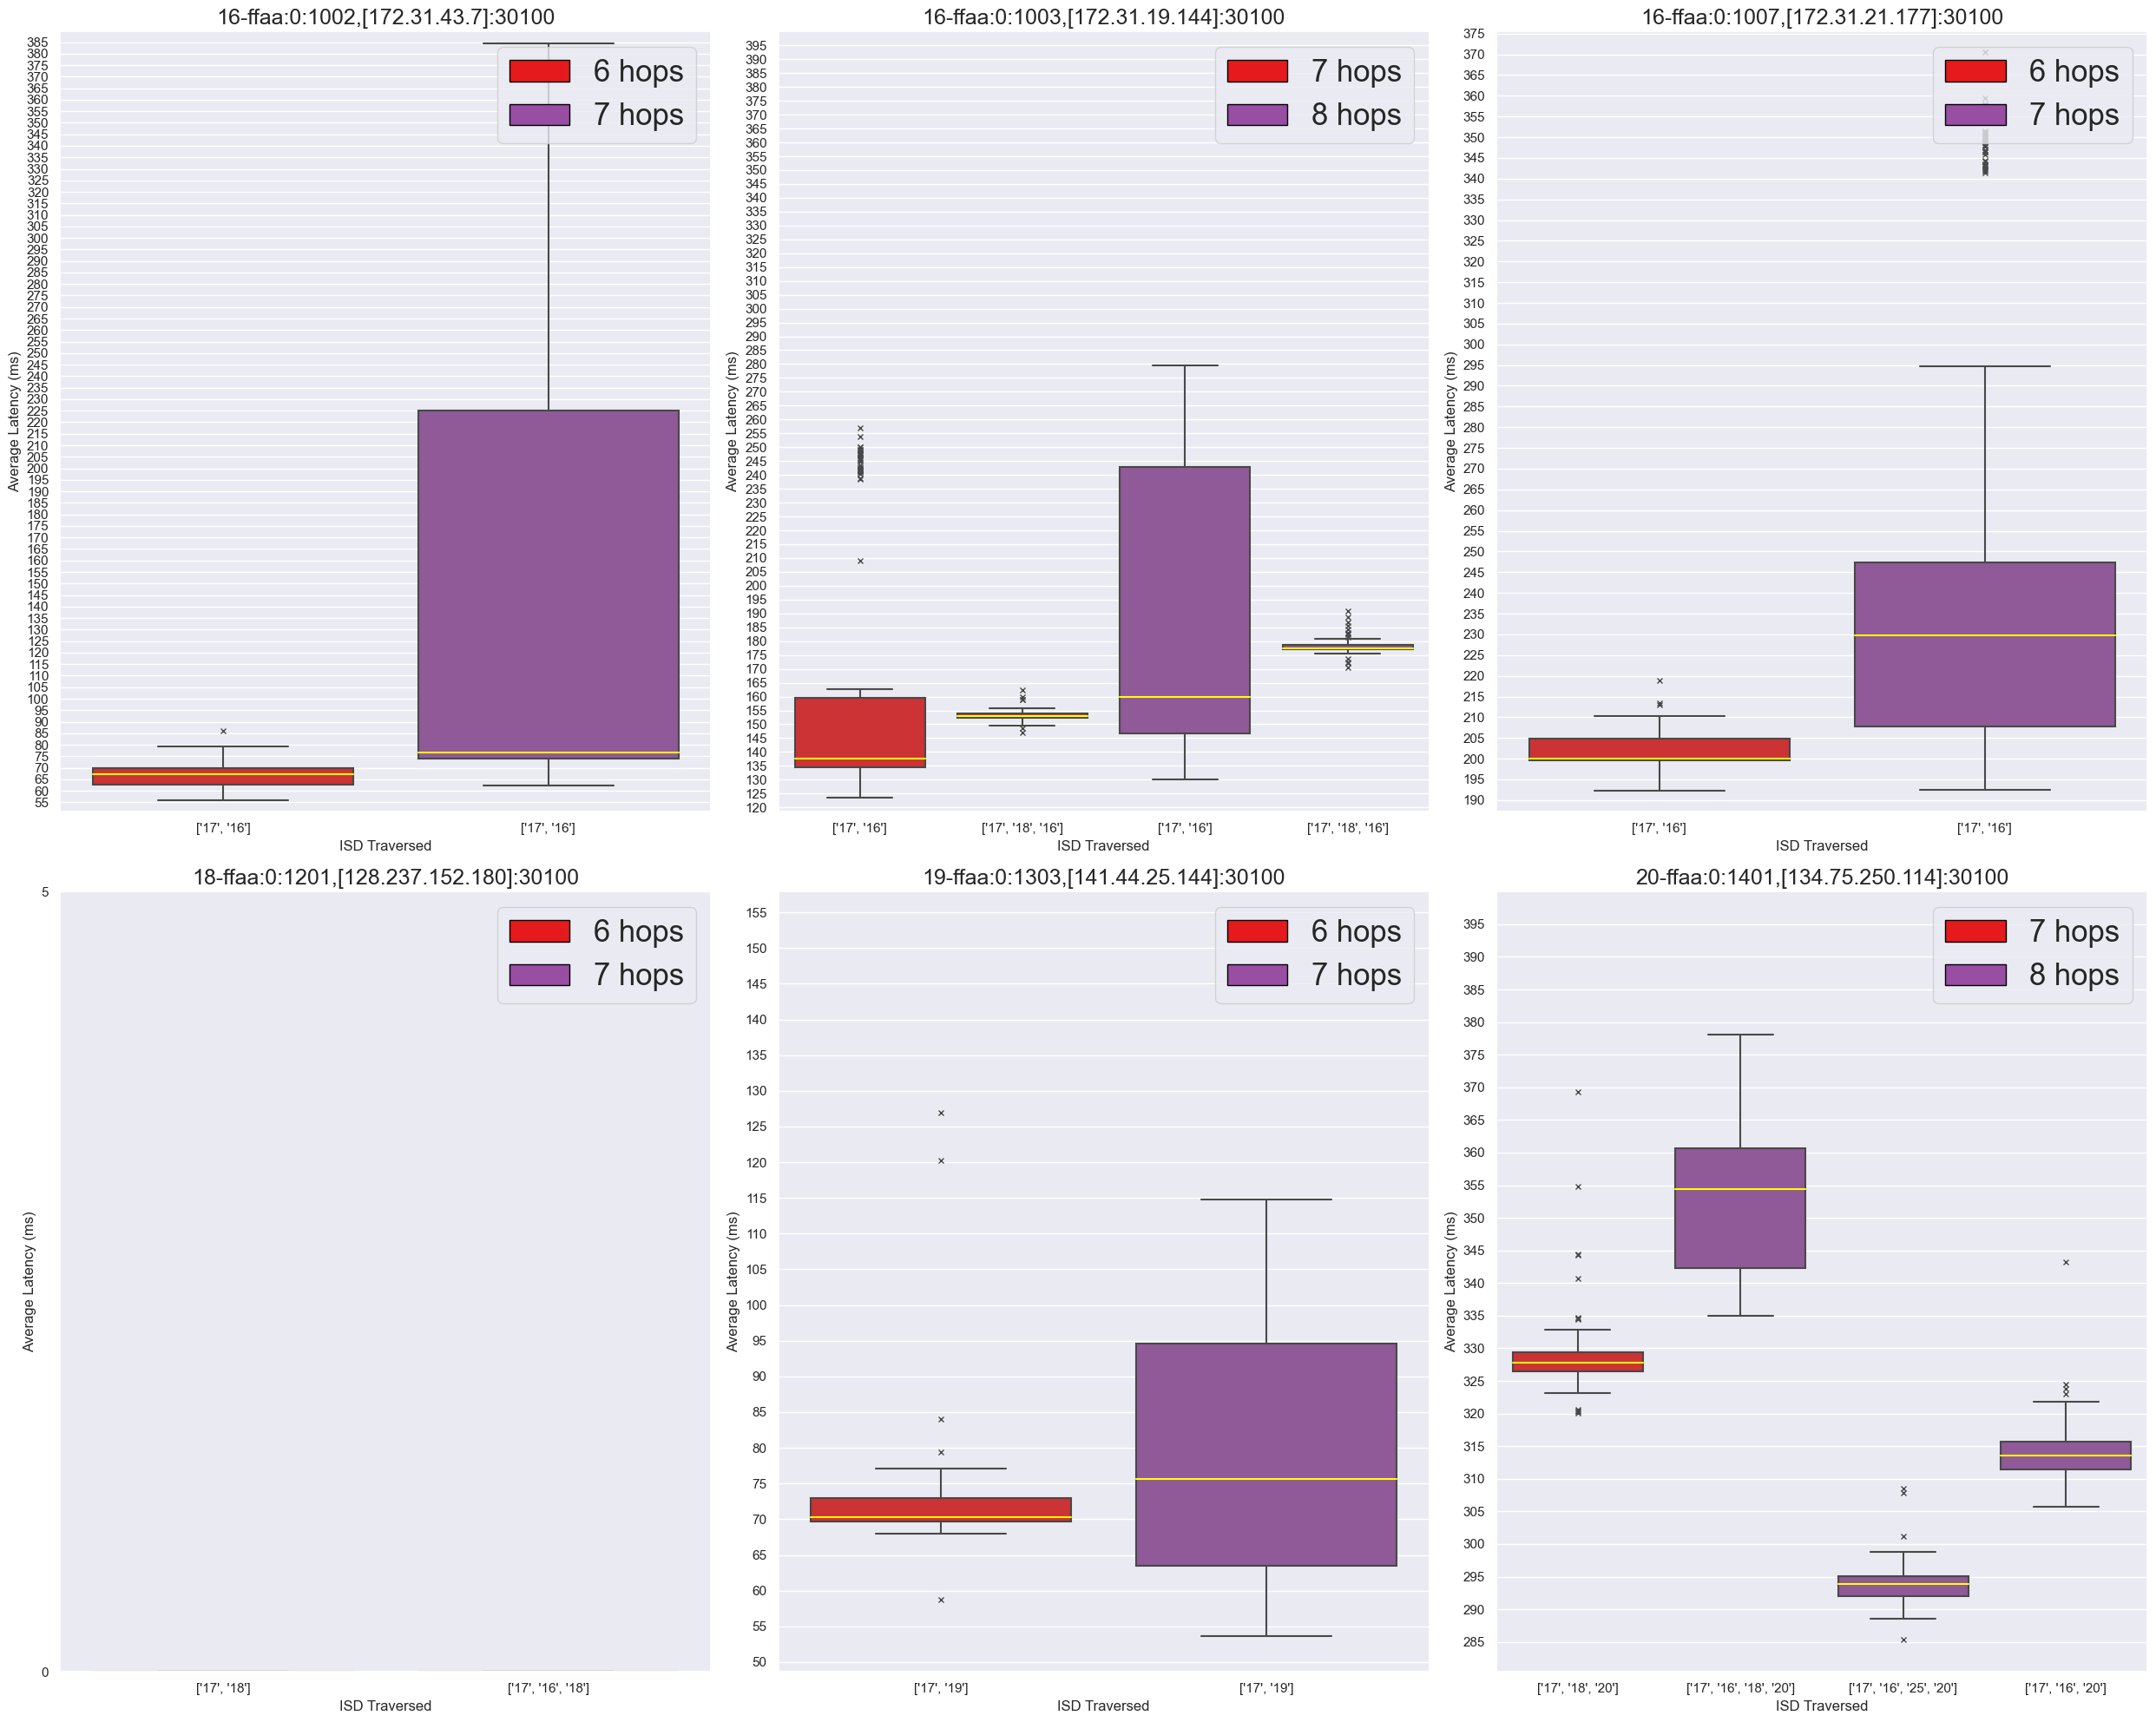

In [50]:
#Latency measured per ISD, grouped by hop count, destination fixed

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))


# Filter the DataFrame to include only the necessary columns
filtered_df = df[['_id', 'avg_latency', 'isolated_domains', 'hops_number', 'color']]

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()
custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
for i, destination in enumerate(destinations):
    ax = axes[i]  # Get the current subplot
    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    
    min_hops = filtered_df[filtered_df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops 
    data = filtered_df[filtered_df['_id'].str.startswith(destination) & (filtered_df['hops_number'] <= min_hops+1)]

    #print(data)
    data = data.copy()
    
    data['isolated_domains'] = data['isolated_domains'].apply(tuple)
    data['x_value'] = data.apply(lambda row: (row['isolated_domains'], row['hops_number']), axis=1)

    #print(data_groupedby_isd_and_hops)

    # Create a sub DataFrame with all the isds for the current destination
    sub_df = [d for _,d in enumerate(data['x_value'].unique())]

    #print(sub_df)
    # Create a list of colors, It retrieves the color of the ISD with the minimum number of hops
    box_color = [data[data['x_value'] == domain]['color'].iloc[0] for domain in sub_df]

    #print(box_color)

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color) if color is not None and not data[data['color'] == color].empty}

    #print(color_hops_dict)

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['x_value'], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)
    
    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}
  
    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in sorted_color_hops_dict.keys()]

    legend_labels = [f"{sorted_color_hops_dict[color]} hops" for color in set(sorted_color_hops_dict.keys())]
    legend_labels.sort(key=lambda x: int(x.split()[0]))
    
    ax.legend(legend_handles, legend_labels, loc='upper right', prop={'size': 25})  # Add the legend to the subplot
    ax.set_xlabel("ISD Traversed")
    ax.set_ylabel("Average Latency (ms)")
    
    min_latency = data['avg_latency'].min()
    max_latency = data['avg_latency'].max()

    ax.set_ylim([max(0, min_latency-5), min(400, max_latency+5)])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    ax.set_title(f"{server}", fontsize=18)  # Set the title for the subplot

    ax.set_xticklabels([str(list(tick[0])) for tick in data['x_value'].unique()])

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()


In [51]:
# Convert bw columns to numeric
df['avg_bandwidth_cs_MTU'] = pd.to_numeric(df['avg_bandwidth_cs_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_sc_MTU'] = pd.to_numeric(df['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_cs_64'] = pd.to_numeric(df['avg_bandwidth_cs_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_sc_64'] = pd.to_numeric(df['avg_bandwidth_sc_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)


In [52]:
# Convert bw columns to numeric
dfbw['avg_bandwidth_cs_MTU'] = pd.to_numeric(dfbw['avg_bandwidth_cs_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
dfbw['avg_bandwidth_sc_MTU'] = pd.to_numeric(dfbw['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
dfbw['avg_bandwidth_cs_64'] = pd.to_numeric(dfbw['avg_bandwidth_cs_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)
dfbw['avg_bandwidth_sc_64'] = pd.to_numeric(dfbw['avg_bandwidth_sc_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)


In [53]:
# Group by destination and pathID, and compute the mean of each bandwidth column
# grouped_df = df.groupby(['_id', 'hops_number', 'color'])[['avg_bandwidth_cs_MTU', 'avg_bandwidth_sc_MTU', 'avg_bandwidth_cs_64', 'avg_bandwidth_sc_64']].mean().reset_index().sort_values(by='_id', key=lambda col: col.str.replace('_', '').astype(int))
# print(grouped_df)
custom_ticks = []
value = 0

while value < 40:
    custom_ticks.append(value)
    value += 2.5

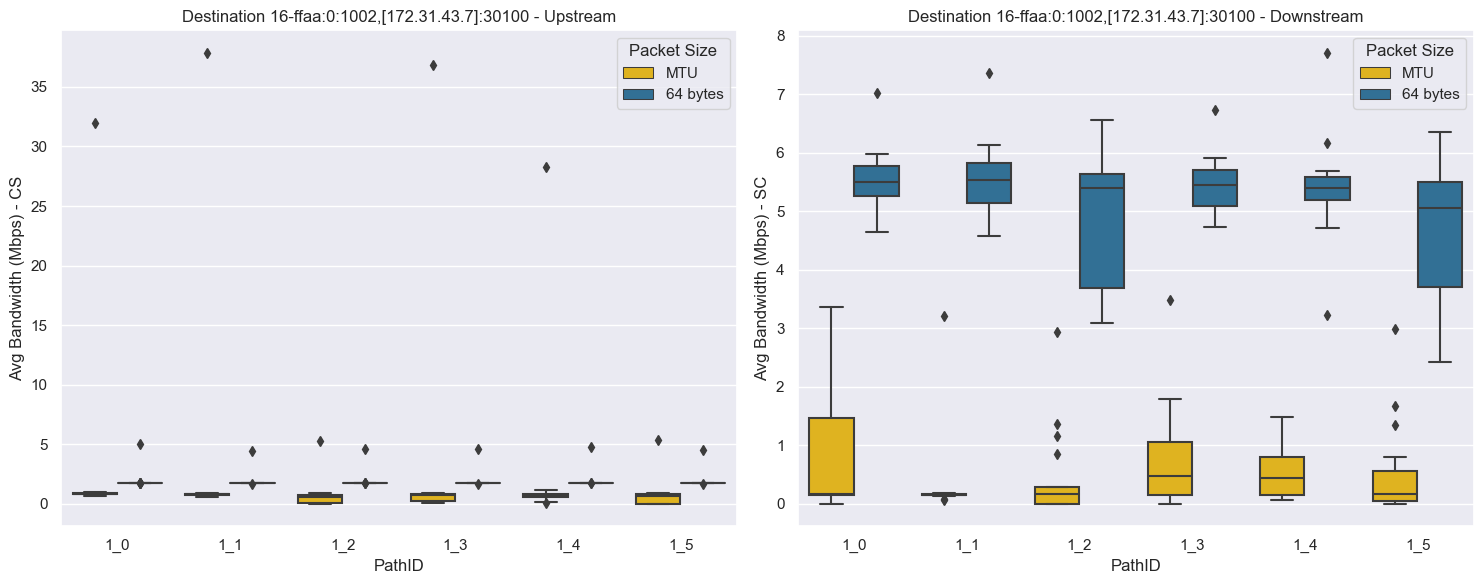

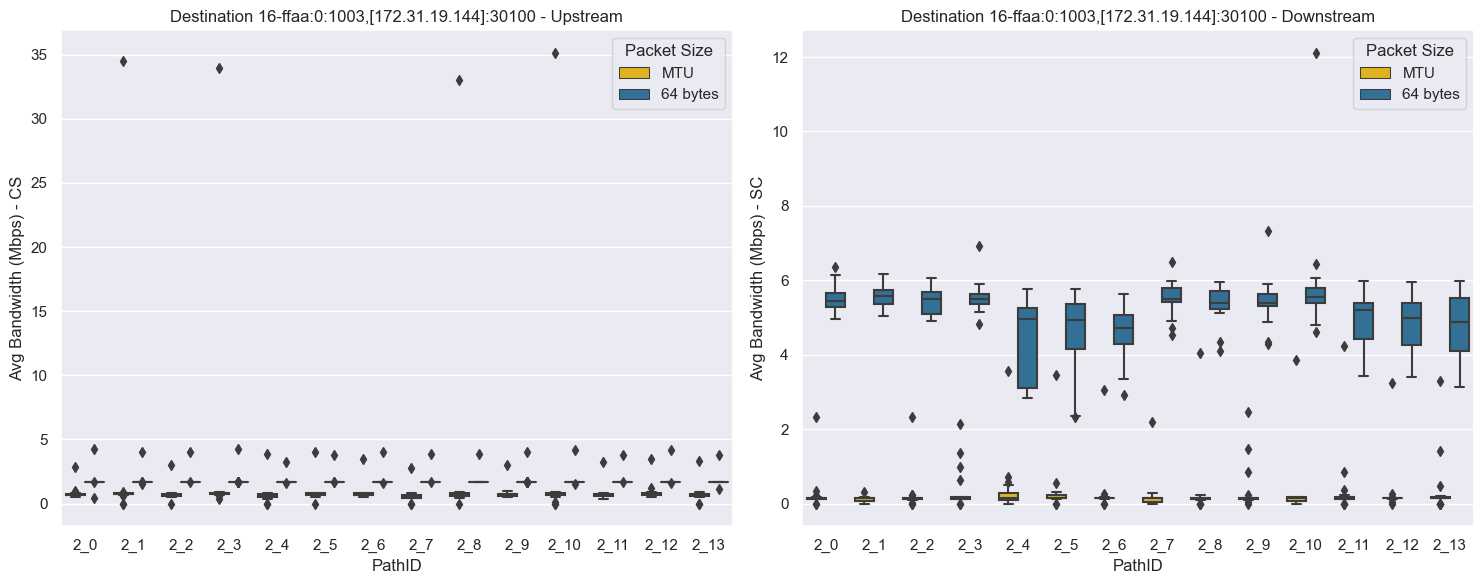

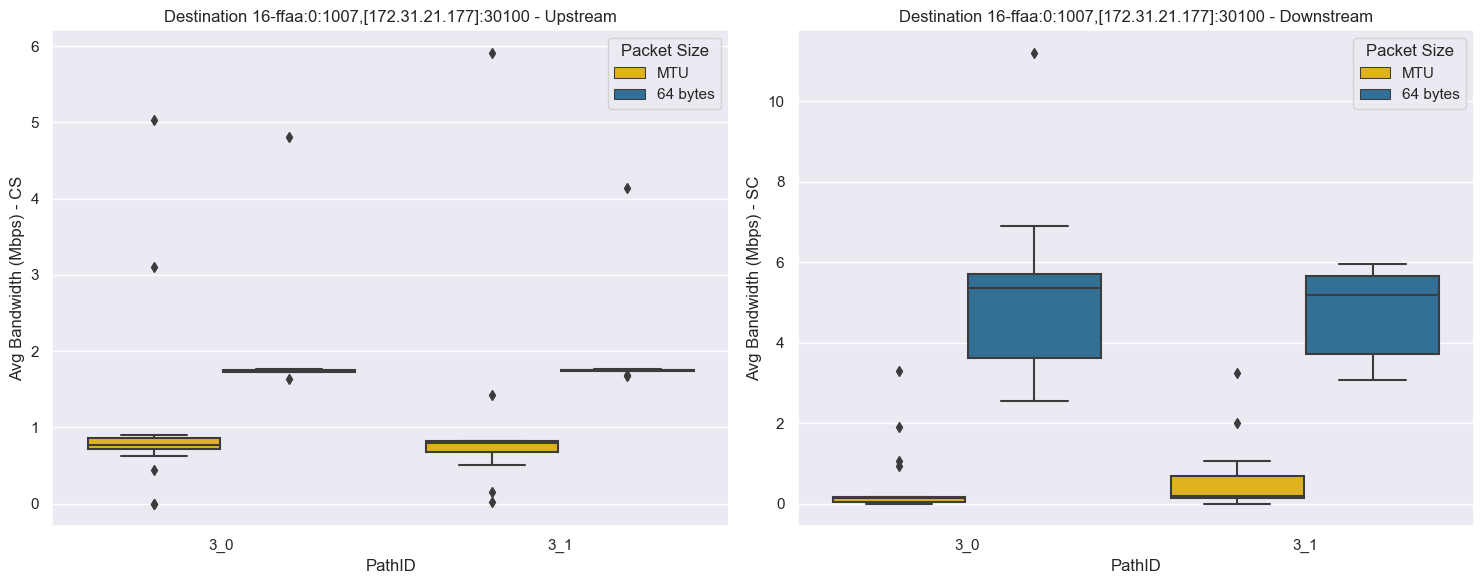

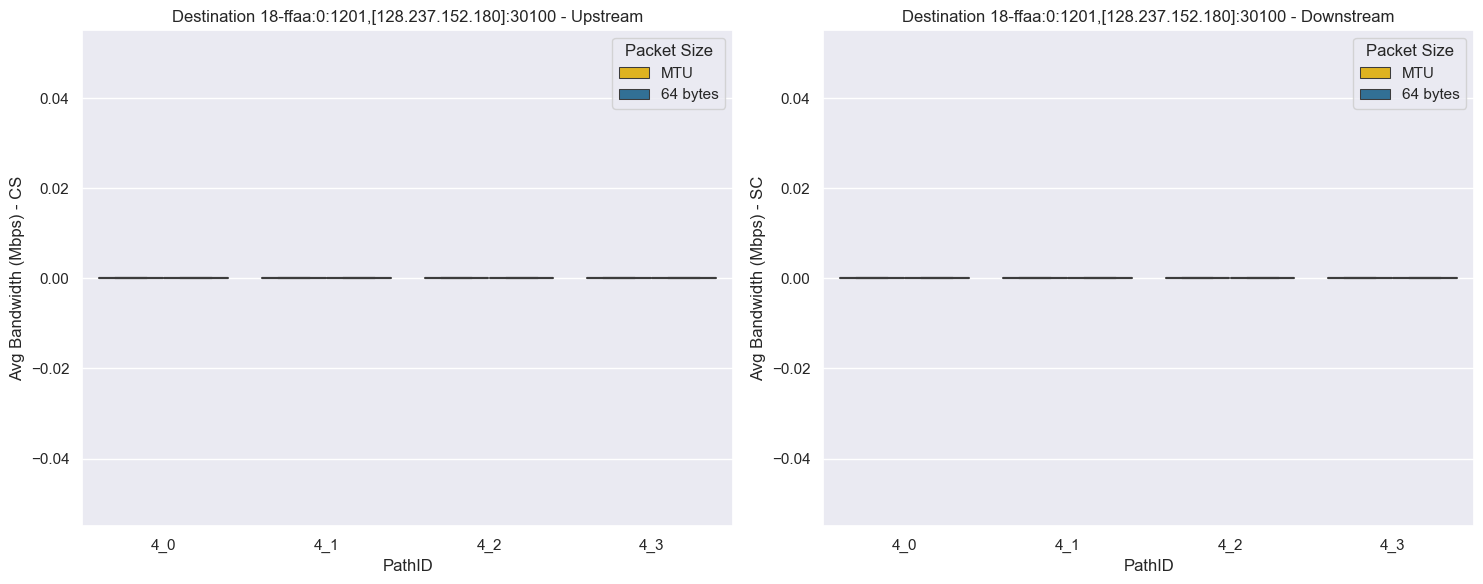

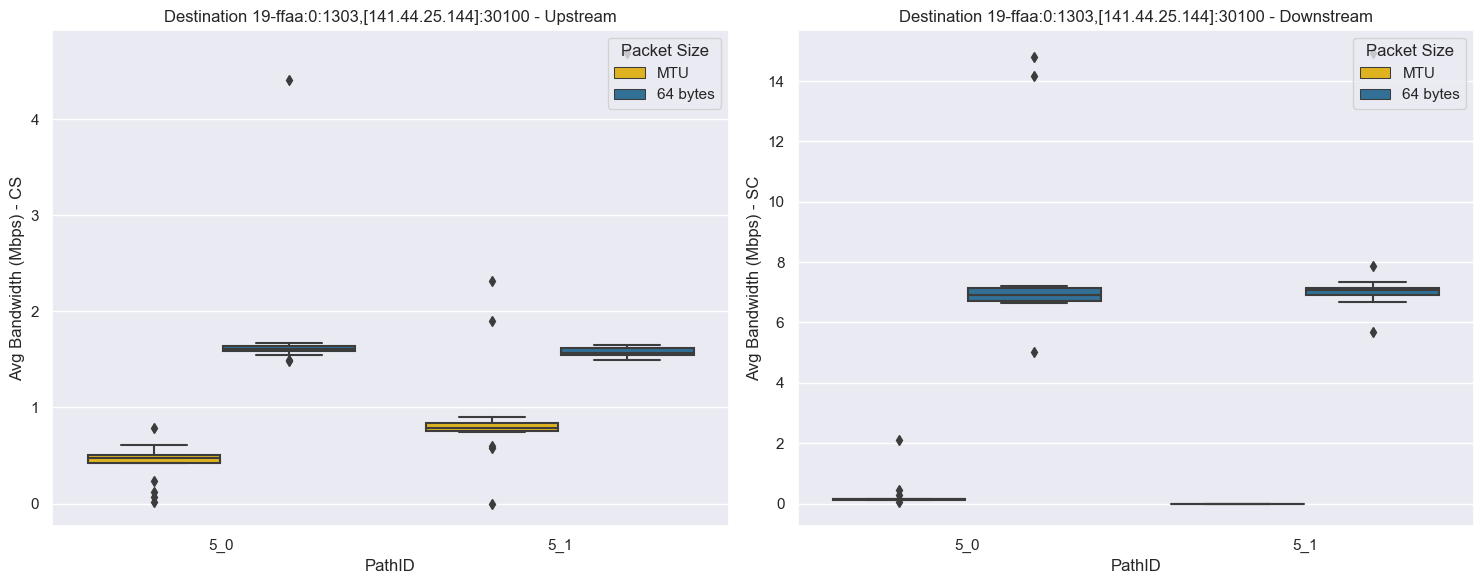

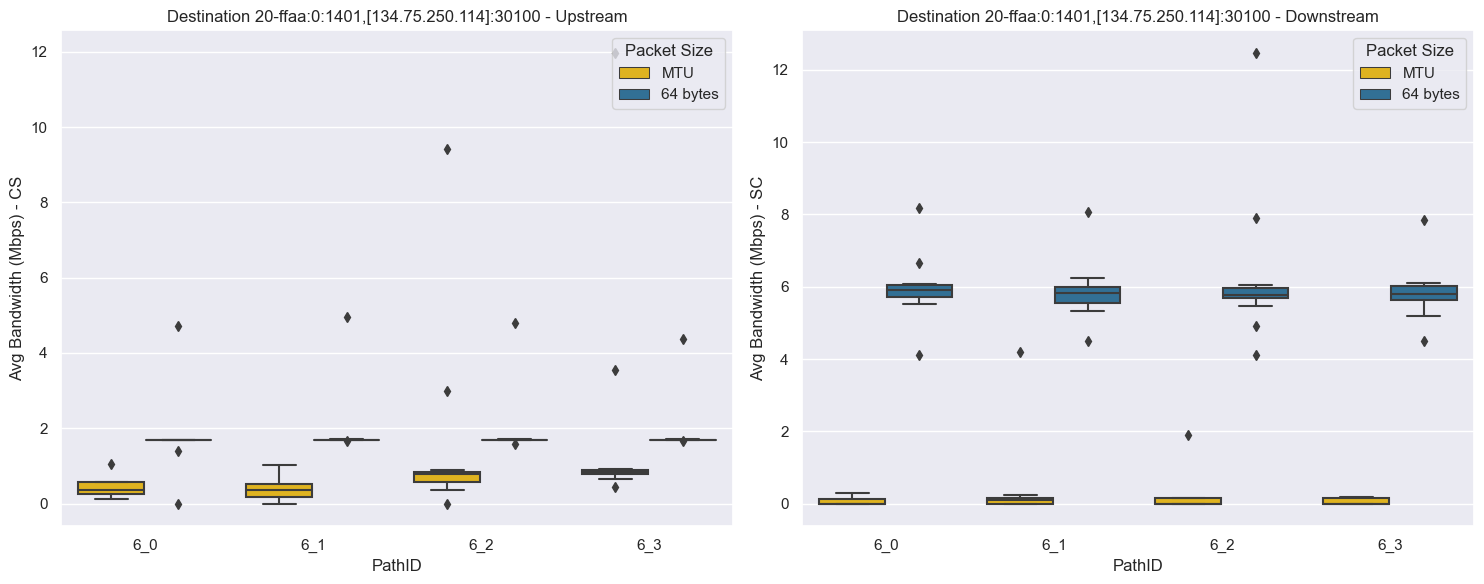

In [54]:
#PLOT FOR THE BANDWIDTH TESTS WITH REQUIRED BW OF 150Mbps (64 BYTES BETTER THAN MTU)

import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over the destinations and create a separate plot for each destination
for destination in destinations:
    # Get the data for the current destination
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()
    data = df[df['_id'].str.startswith(destination) & (df['hops_number'] == min_hops)]

    # Create the figure for the current destination
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Create the subplots for upstream and downstream bandwidth
    ax1 = axes[0]
    ax2 = axes[1]

    # Concatenate the data for MTU and 64, and create a new 'type' column
    data_mtu = data[['avg_bandwidth_cs_MTU', 'avg_bandwidth_cs_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)
    data_64 = data[['avg_bandwidth_sc_MTU', 'avg_bandwidth_sc_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)

    # Create Gaussians for MTU packet size
    sns.boxplot(data=data_mtu, x='_id', y='avg_bandwidth', hue='type', ax=ax1, palette={"avg_bandwidth_cs_MTU": "#ffc400", "avg_bandwidth_cs_64": "#2274a5"})
    sns.boxplot(data=data_64, x='_id', y='avg_bandwidth', hue='type', ax=ax2, palette={"avg_bandwidth_sc_MTU": "#ffc400", "avg_bandwidth_sc_64": "#2274a5"})

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Set the titles and labels
    ax1.set_title(f"Destination {server} - Upstream")
    ax2.set_title(f"Destination {server} - Downstream")

    ax1.set_ylabel("Avg Bandwidth (Mbps) - CS")
    ax2.set_ylabel("Avg Bandwidth (Mbps) - SC")

    ax1.set_xlabel("PathID")
    ax2.set_xlabel("PathID")

    # Add a legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')
    ax2.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Close the current figure to create a new one for the next destination
    plt.savefig(f"../../graphs/Bandwidth Whiskers/bw_destination_{destination}.png")
    plt.show()    
    plt.close()


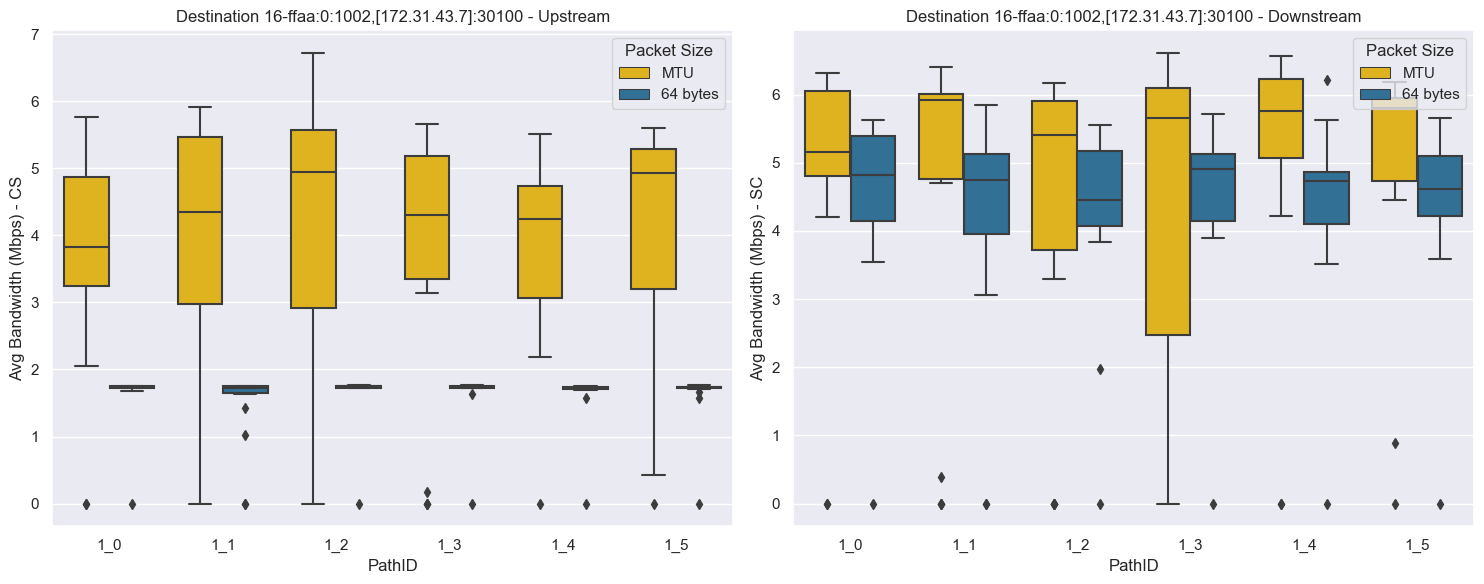

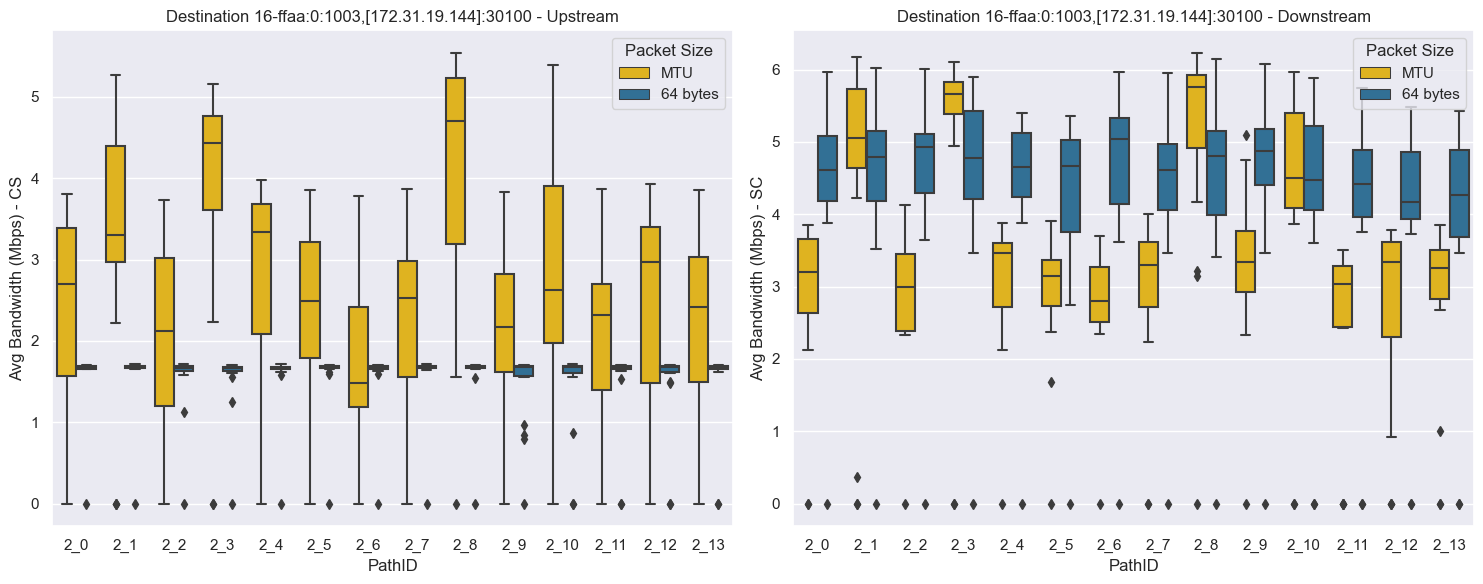

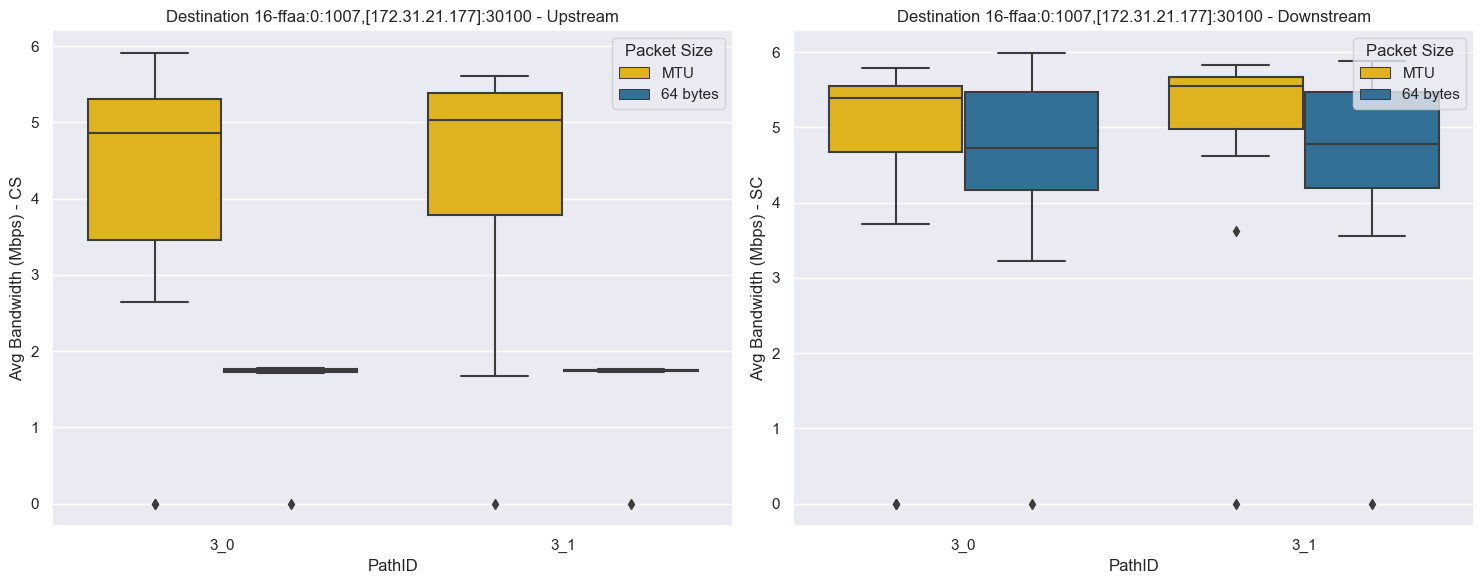

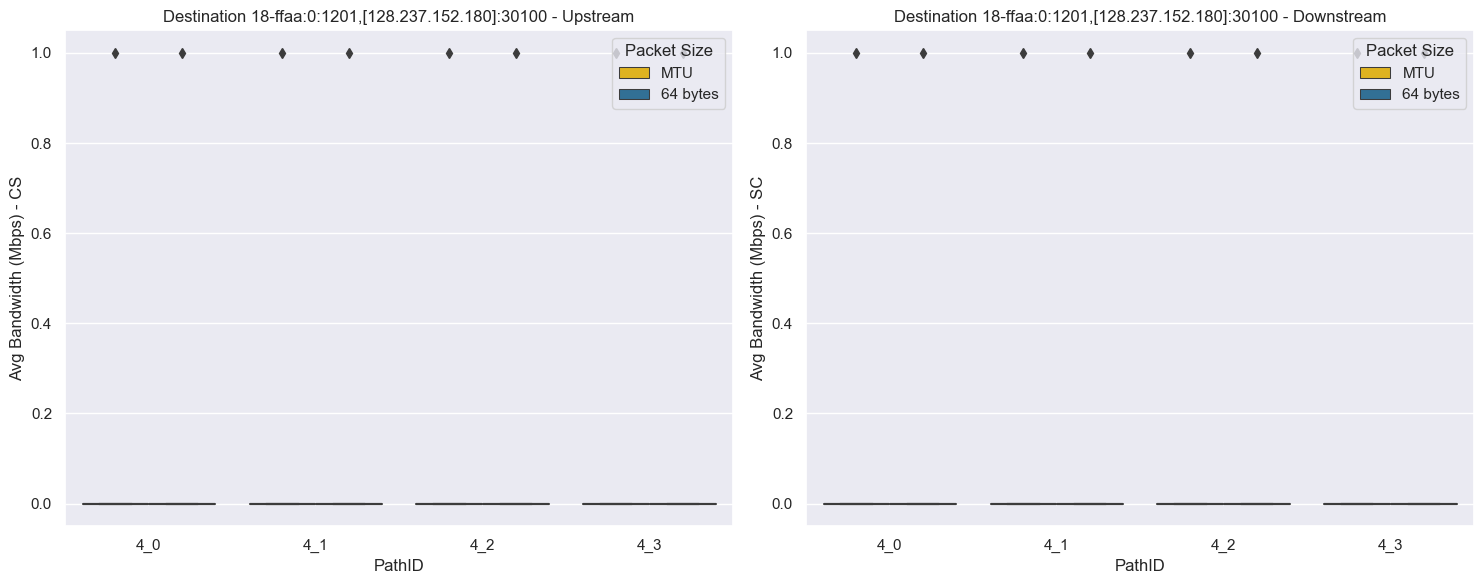

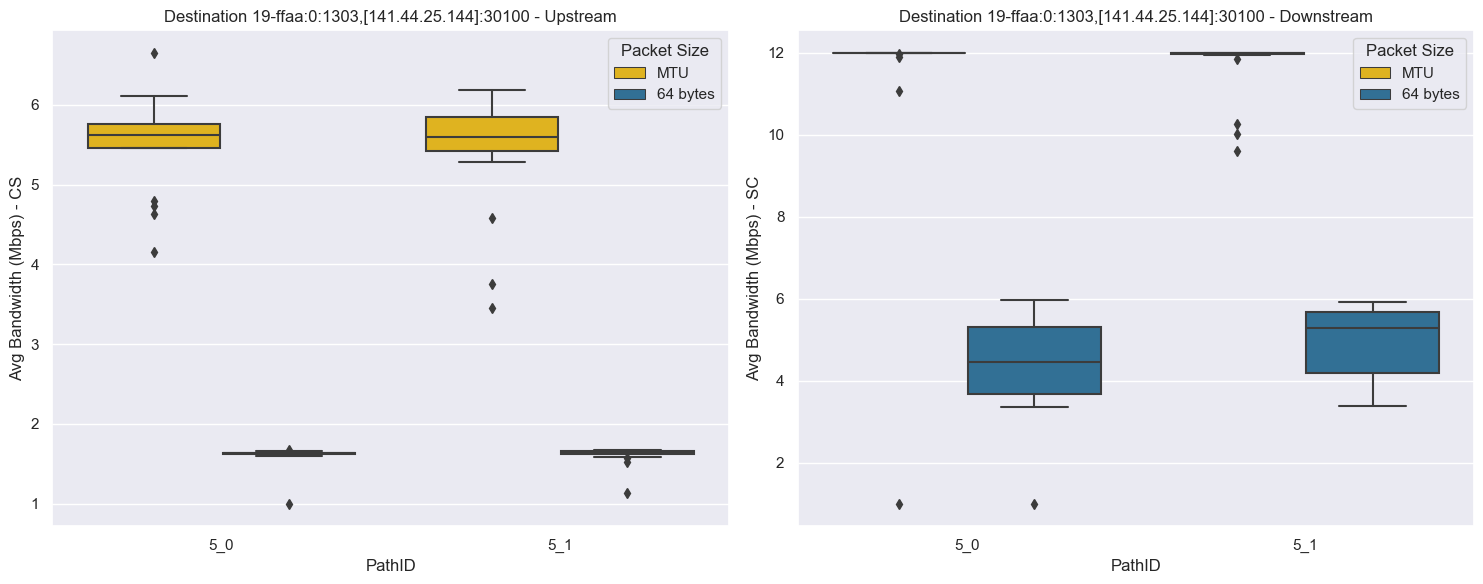

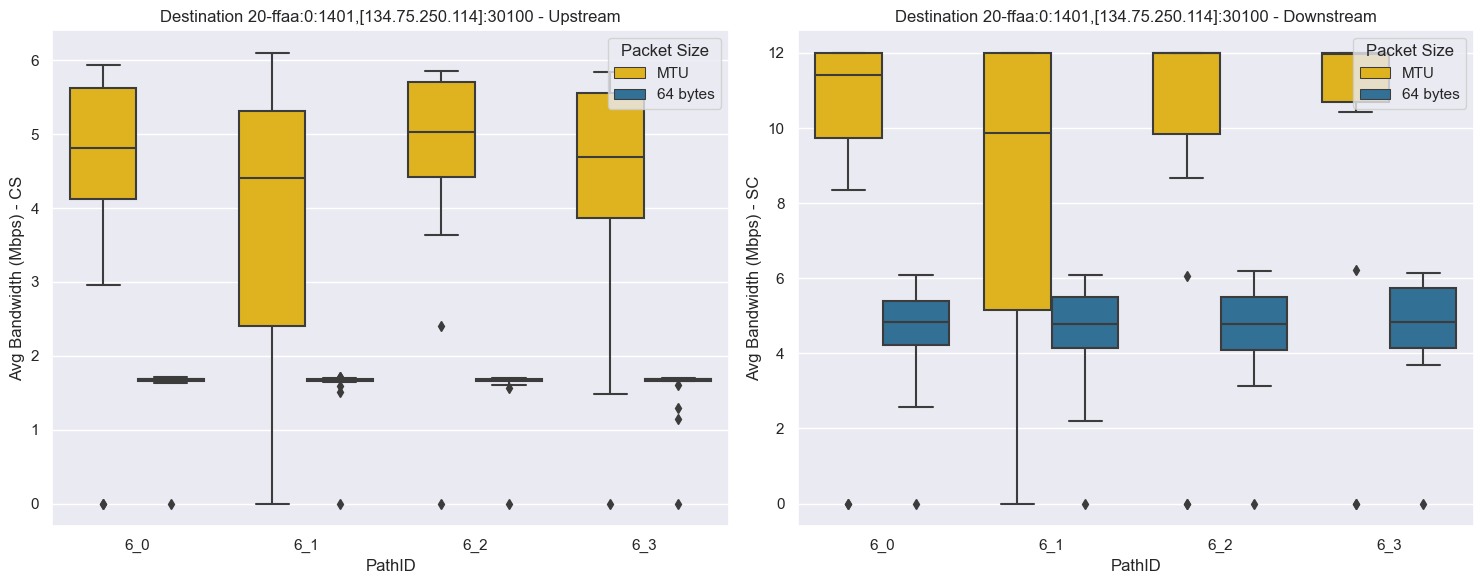

In [55]:
#PLOT FOR THE BANDWIDTH TESTS WITH REQUIRED BW OF 12Mbps (MTU BETTER THAN 64 BYTES)

# Iterate over the destinations and create a separate plot for each destination
for destination in destinations:
    # Get the data for the current destination
    min_hops = dfbw[dfbw['_id'].str.startswith(destination)]['hops_number'].min()
    data = dfbw[dfbw['_id'].str.startswith(destination) & (dfbw['hops_number'] == min_hops)]

    # Create the figure for the current destination
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Create the subplots for upstream and downstream bandwidth
    ax1 = axes[0]
    ax2 = axes[1]

    # Concatenate the data for MTU and 64, and create a new 'type' column
    data_mtu = data[['avg_bandwidth_cs_MTU', 'avg_bandwidth_cs_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)
    data_64 = data[['avg_bandwidth_sc_MTU', 'avg_bandwidth_sc_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)

    # Create Gaussians for MTU packet size
    sns.boxplot(data=data_mtu, x='_id', y='avg_bandwidth', hue='type', ax=ax1, palette={"avg_bandwidth_cs_MTU": "#ffc400", "avg_bandwidth_cs_64": "#2274a5"})
    sns.boxplot(data=data_64, x='_id', y='avg_bandwidth', hue='type', ax=ax2, palette={"avg_bandwidth_sc_MTU": "#ffc400", "avg_bandwidth_sc_64": "#2274a5"})

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Set the titles and labels
    ax1.set_title(f"Destination {server} - Upstream")
    ax2.set_title(f"Destination {server} - Downstream")

    ax1.set_ylabel("Avg Bandwidth (Mbps) - CS")
    ax2.set_ylabel("Avg Bandwidth (Mbps) - SC")

    ax1.set_xlabel("PathID")
    ax2.set_xlabel("PathID")

    # Add a legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')
    ax2.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Close the current figure to create a new one for the next destination
    plt.savefig(f"../../graphs/Bandwidth Whiskers/bw_destination_{destination}.png")
    plt.show()    
    plt.close()


In [56]:
df['avg_loss'] = pd.to_numeric(df['avg_loss'].str.replace('%', ''), errors='coerce').fillna(0)

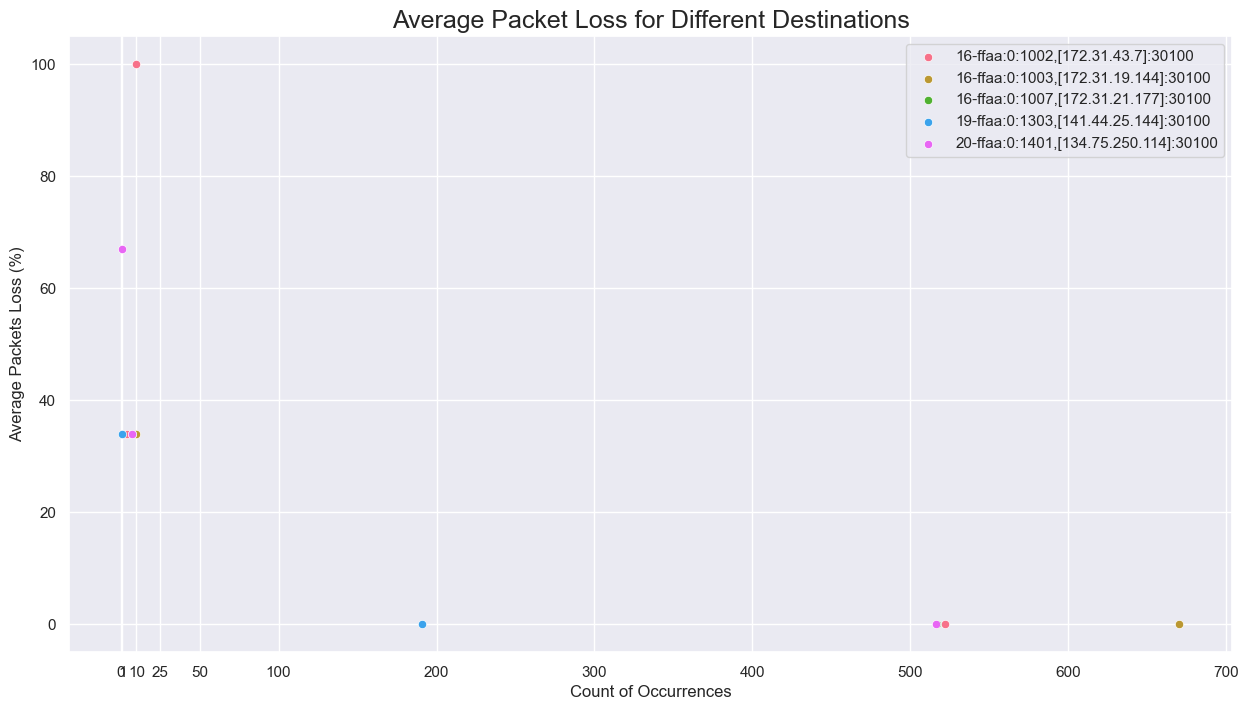

In [64]:
# Define plot for the average packet loss for each destination
fig, ax = plt.subplots(figsize=(15, 8))

# Create a custom color palette with unique colors for each destination
color_palette = sns.color_palette("husl", len(destinations))
data = df.copy()
# Iterate over destinations and create a scatter plot for each
for i, destination in enumerate(destinations):
    if destination == '4':
        continue
    # Filter the DataFrame for the current destination
    dest_data = data[data['_id'].str.startswith(destination)]
    
    # Count the occurrences for each loss percentage and create a new DataFrame
    loss_counts = dest_data['avg_loss'].value_counts().reset_index()

    loss_counts.columns = ['avg_loss', 'count']

    dest_addr = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]
    # Plot the scatter plot for the current destination
    sns.scatterplot(data=loss_counts, x=loss_counts['count'], y="avg_loss", color=color_palette[i], ax=ax, label=dest_addr)

# Set the x-axis label to indicate the count of occurrences
ax.set_xlabel("Count of Occurrences")

# Set the y-axis label to show the Average Packet Loss
ax.set_ylabel("Average Packets Loss (%)")

# Set the title for the subplot
ax.set_title("Average Packet Loss for Different Destinations", fontsize=18)

# Define your custom scale for the x-axis
custom_ticks = [0, 1, 10, 25, 50, 100, 200, 300, 400, 500, 600, 700]
custom_labels = ['0', "1", "10", "25", "50", '100', '200', '300', '400', '500', '600', '700']

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_ticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(12, custom_ticks))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(custom_labels))

# Show the legend
ax.legend()

# Show the plot
plt.show()

_id                     536
avg_latency             536
avg_bandwidth_cs_64     536
avg_bandwidth_sc_64     536
avg_bandwidth_cs_MTU    536
avg_bandwidth_sc_MTU    536
hops                    536
isolated_domains        536
avg_loss                536
timestamp               536
hops_number             536
dest                    536
color                   536
dtype: int64
0 100
229      34
1066    100
1067    100
1068    100
1069    100
1070    100
1071    100
1072    100
1073    100
1074    100
1075    100
1498     34
2146     34
2436     34
Name: avg_loss, dtype: int64


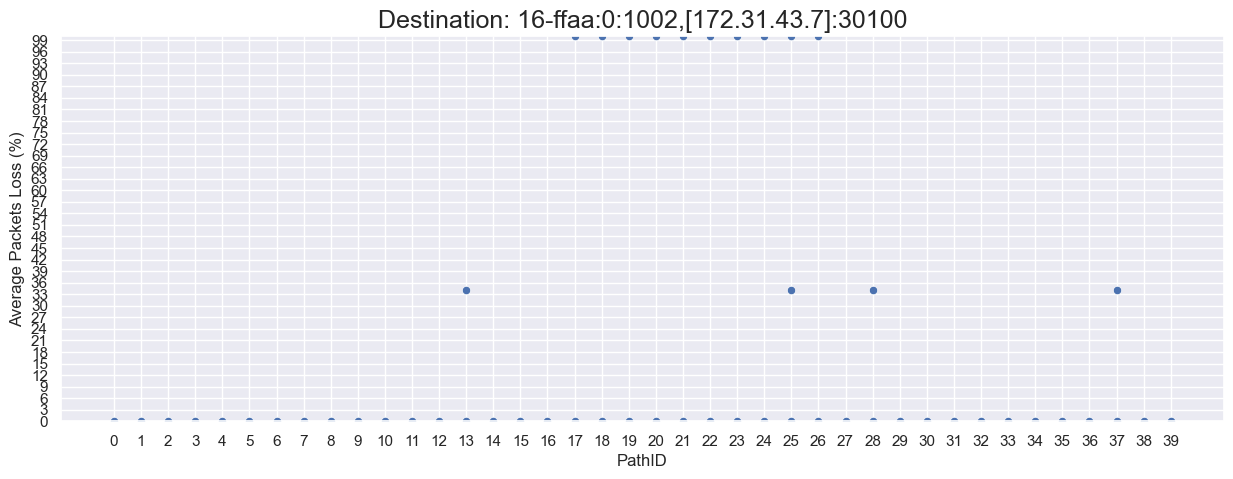

_id                     680
avg_latency             680
avg_bandwidth_cs_64     680
avg_bandwidth_sc_64     680
avg_bandwidth_cs_MTU    680
avg_bandwidth_sc_MTU    680
hops                    680
isolated_domains        680
avg_loss                680
timestamp               680
hops_number             680
dest                    680
color                   680
dtype: int64
0 34
246     34
903     34
1529    34
2367    34
2368    34
2370    34
2372    34
2373    34
2446    34
2562    34
Name: avg_loss, dtype: int64


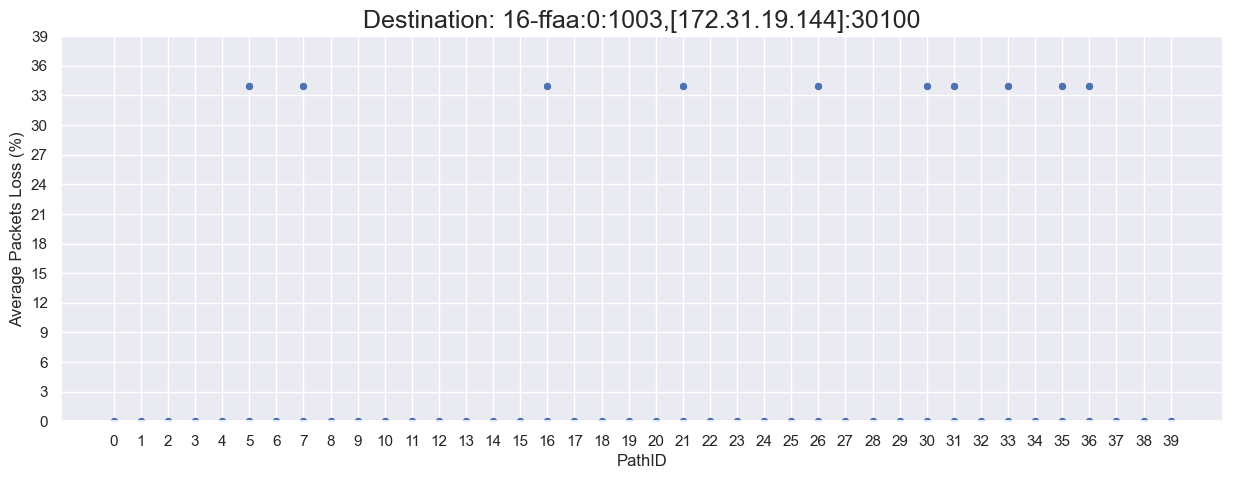

_id                     524
avg_latency             524
avg_bandwidth_cs_64     524
avg_bandwidth_sc_64     524
avg_bandwidth_cs_MTU    524
avg_bandwidth_sc_MTU    524
hops                    524
isolated_domains        524
avg_loss                524
timestamp               524
hops_number             524
dest                    524
color                   524
dtype: int64
0 34
80      34
1560    34
1563    34
1579    34
1581    34
1584    34
2386    34
Name: avg_loss, dtype: int64


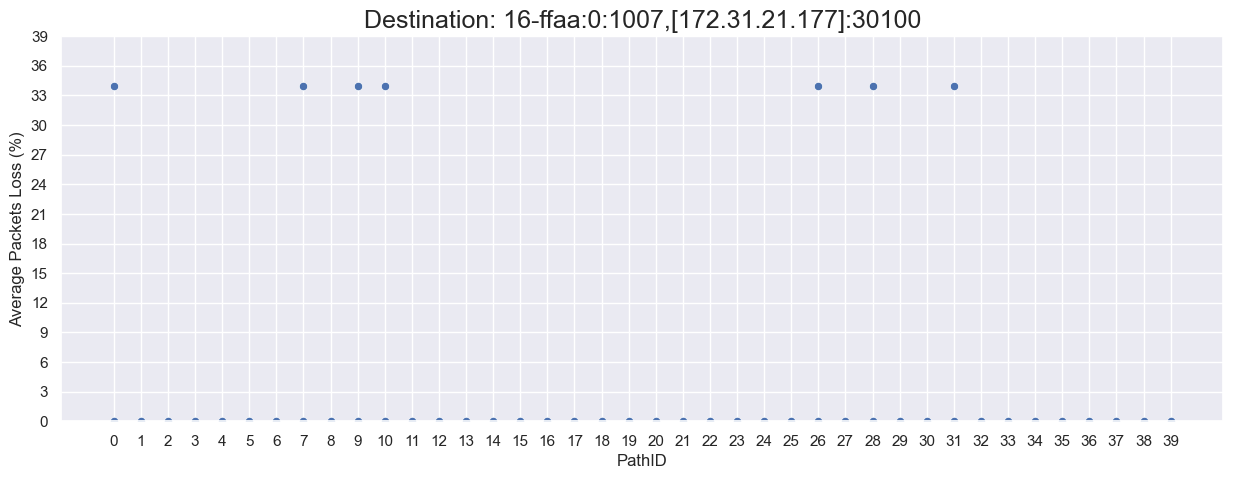

_id                     477
avg_latency             477
avg_bandwidth_cs_64     477
avg_bandwidth_sc_64     477
avg_bandwidth_cs_MTU    477
avg_bandwidth_sc_MTU    477
hops                    477
isolated_domains        477
avg_loss                477
timestamp               477
hops_number             477
dest                    477
color                   477
dtype: int64
100 100
120     100
121     100
122     100
123     100
124     100
       ... 
2904    100
2905    100
2906    100
2907    100
2908    100
Name: avg_loss, Length: 477, dtype: int64


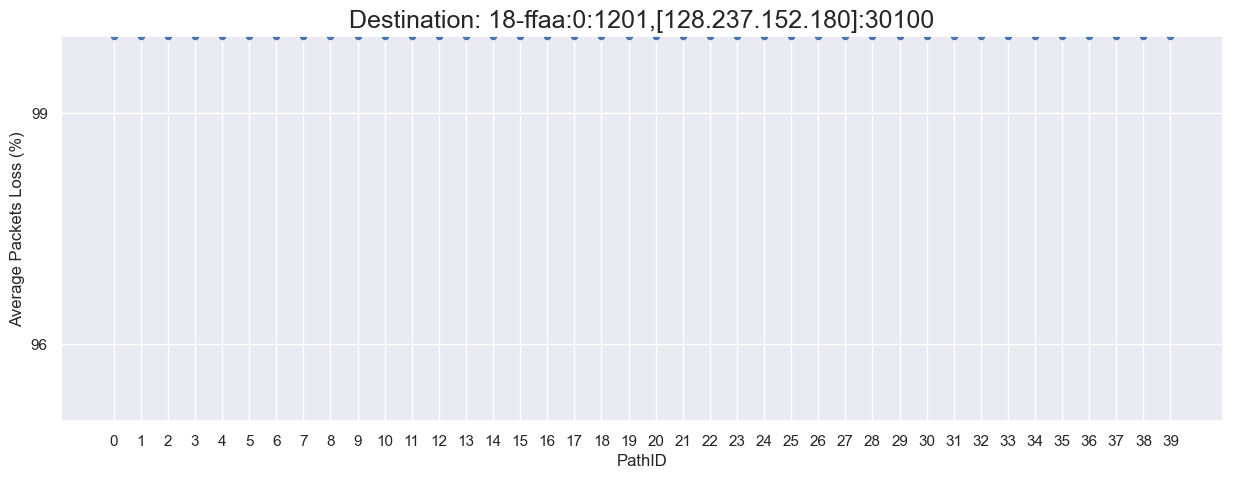

_id                     192
avg_latency             192
avg_bandwidth_cs_64     192
avg_bandwidth_sc_64     192
avg_bandwidth_cs_MTU    192
avg_bandwidth_sc_MTU    192
hops                    192
isolated_domains        192
avg_loss                192
timestamp               192
hops_number             192
dest                    192
color                   192
dtype: int64
0 34
2400    34
Name: avg_loss, dtype: int64


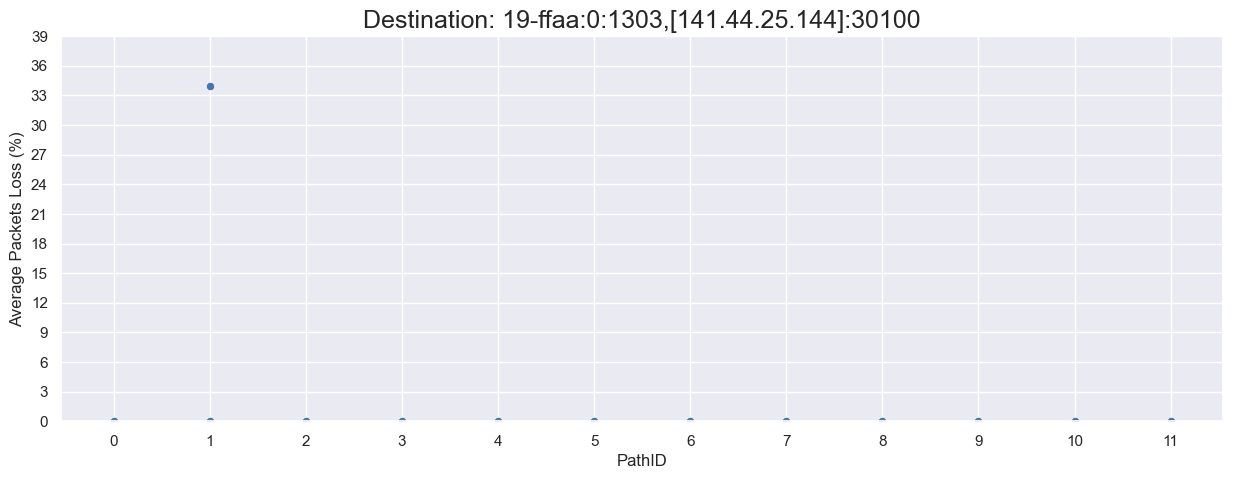

_id                     524
avg_latency             524
avg_bandwidth_cs_64     524
avg_bandwidth_sc_64     524
avg_bandwidth_cs_MTU    524
avg_bandwidth_sc_MTU    524
hops                    524
isolated_domains        524
avg_loss                524
timestamp               524
hops_number             524
dest                    524
color                   524
dtype: int64
0 67
1233    67
1651    34
2099    34
2305    34
2306    34
2617    34
2619    34
2931    34
Name: avg_loss, dtype: int64


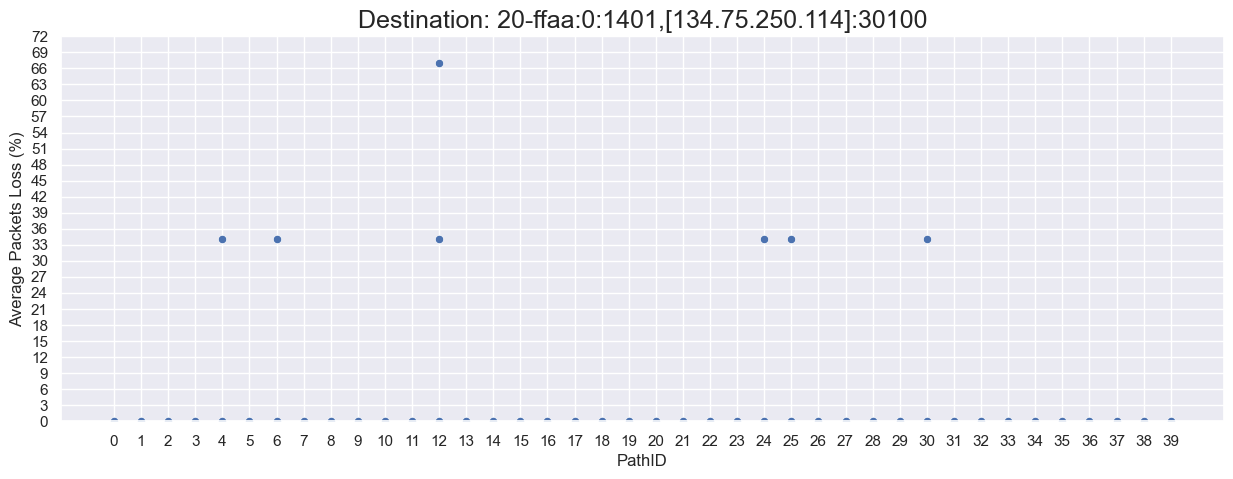

In [20]:
# # THIS IS THE CODE FOR THE PLOT OF THE LOSS FOR EACH PATH FOR EACH DESTINATION. (WHISKER PLOT)

custom_ticks = []

for i in range(0, 100, 3):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
# Iterate over destinations and create a graph for each
for destination in destinations:
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()

    paths_lines = df[df['_id'].str.startswith(destination)].count()
    print(paths_lines)
    # Filter the DataFrame for the current destination and minimum number of hops +1 
    data = df[df['_id'].str.startswith(destination)]

    min_loss = data['avg_loss'].min()
    max_loss = data[data['avg_loss'] <= 100]['avg_loss'].max()
    
    print(min_loss, max_loss)
    lower_bound = max(0, min_loss-5)
    upper_bound = min(100, max_loss+5)

    # print(max_latency)

    graph_height = upper_bound - lower_bound
    
    graph_height = graph_height/22.5 if not (graph_height/22.5) - 5 <= 0 else 5

    # Create a new figure for each destination
    fig, ax = plt.subplots(figsize=(15, graph_height))

    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    ax.set_xlabel("PathID")
    ax.set_ylabel("Average Packets Loss (%)")

    ax.set_ylim([lower_bound, upper_bound])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Create a sub DataFrame with all the ids for the current destination
    sub_df = [d for i,d in enumerate(data['_id'].unique())]

    # Create a list of colors for each pathID in the current destination
    box_color = [data[data['_id'] == id]['color'].iloc[0] for id in sub_df]

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color)}

    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}

    print(data[data['avg_loss'] > 0]['avg_loss'])
    # Create the scatter plot for the current destination
    sns.scatterplot(data=data, x=data['_id'].str.split('_', expand=True)[1], y="avg_loss", palette=box_color, ax=ax)
    # sns.boxplot(data=data, x=data['_id'].str.split('_', expand=True)[1], y="avg_loss",  flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, )

    ax.set_title(f"Destination: {server}", fontsize=18)  # Set the title for the subplot

    # Show the current figure
    plt.show()